# Data

## Read data

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import os 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


You can get the Credit Card Fraud Detection dataset from:
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
data_path = os.path.join("..","data","creditcard.csv")
data = pd.read_csv(data_path)
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Prepare data

In [4]:
train, test = train_test_split(data, test_size=0.7, random_state=42)
train = train.drop(columns=["Amount","Time"])
test = test.drop(columns=["Amount","Time"])
X_train, y_train = train.drop(columns=["Class"]), train["Class"]
X_test, y_test = test.drop(columns=["Class"]), test["Class"]

train_inliers = train[train.Class==0]
train_inliers = train_inliers.drop(['Class'], axis=1)
train_outliers = train[train.Class==1]
train_outliers = train_outliers.drop(['Class'], axis=1)

test_inliers = test[test.Class==0]
test_inliers = test_inliers.drop(['Class'], axis=1)
test_outliers = test[test.Class==1]
test_outliers = test_outliers.drop(['Class'], axis=1)

# KNN type models need to standartize the featrues
sc = StandardScaler()
sc.fit(train_inliers.values)
train_inliers_sc = sc.transform(train_inliers.values)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

print(f"Inliers Train shape: {train_inliers.shape}")
print(f"Outliers Train shape: {train_outliers.shape}")

print(f"Inliers Test shape: {test_inliers.shape}")
print(f"Outliers Test shape: {test_outliers.shape}")


Inliers Train shape: (85284, 28)
Outliers Train shape: (158, 28)
Inliers Test shape: (199031, 28)
Outliers Test shape: (334, 28)


# Models

## Main metric - Recall@K

In [5]:
def recall(df, k, ascending=True):
    true_col_name = df.columns[0]
    pred_col_name = df.columns[1]
    top_true = df.sort_values(pred_col_name, ascending=ascending).head(k)[true_col_name].sum()
    total_true = df[true_col_name].sum()
    recall_at_k =  top_true / total_true
    return recall_at_k

def get_recall_at_k_range(results_df, k_range, ascending=True):
    results_dict = {"K":[], "Recall@k":[]}
    for k in k_range:
        results_dict["K"].append(k)
        result = recall(results_df, k, ascending=ascending)
        results_dict["Recall@k"].append(result)

    results_df = pd.DataFrame(results_dict)
    return results_df
    
def print_recall_at_k_graph(results_df, title="Recall@k"):
    results_df.plot(x="K",y="Recall@k",title=title)
    plt.show()
    
def collect_results(train_preds_df, test_preds_df, ytrain, ytest, k, wanted_range, ascending=True):
    X_train_concat_results = pd.concat([pd.DataFrame(ytrain).reset_index(drop=True),
                                        train_preds_df], axis=1)

    X_test_concat_results = pd.concat([pd.DataFrame(ytest).reset_index(drop=True),
                                        test_preds_df], axis=1)

    # Plot Recall@k graphs
    train_recall_at_k_results = get_recall_at_k_range(X_train_concat_results, wanted_range, ascending=ascending)
    print_recall_at_k_graph(train_recall_at_k_results, "Train Recall@k")

    test_recall_at_k_results = get_recall_at_k_range(X_test_concat_results, wanted_range, ascending=ascending)
    print_recall_at_k_graph(test_recall_at_k_results, "Test Recall@k")

    # Calc Recall@k AUC
    denominator = train_recall_at_k_results["K"].min() + train_recall_at_k_results["K"].max()
    train_recall_at_k_auc = metrics.auc(train_recall_at_k_results["K"], train_recall_at_k_results["Recall@k"]/denominator)
    test_recall_at_k_auc = metrics.auc(test_recall_at_k_results["K"], test_recall_at_k_results["Recall@k"]/denominator)
    print(f"Train Recall@{k}: {recall(X_train_concat_results, k, ascending=ascending)}")
    print(f"Train Recall@{k} AUC: {train_recall_at_k_auc}")
    print()
    print(f"Test Recall@{k}: {recall(X_test_concat_results, k, ascending=ascending)}")
    print(f"Test Recall@{k} AUC: {test_recall_at_k_auc}")
    
    

In [6]:
k_total = 10_000 # used to evaluate the models
k_optimize = 2_000 # used to optimize the models - More important that anomalies will be ranked at the first k_optimize instances
wanted_range = range(1000,10_000,1000) 

## Evaluation methodology

- I chose to use recall@k because, in many anomaly detection tasks, we will pass our predictions to human expert for another validation. However, the human expert can't examine all of the predictions, therefore, we will select top-k (k depend on human capacity) most anomalous instances and pass them for human inspection. 

- I also chose to report Recall@k area under the curve. It's the same as well known AUC of the ROC curve, but when the curve is of recall results over different K values. Even though the dataset is larger than 10K instances, I chose to look at top instances up to top 10K most anomalous ones because I thought this is a reasonable amount of instances for human inspection. I also investigated the results of top 2K most anomalous instances to further understand the differences between the models.


- I compare two models, Isolation Forest and INNE.


- The evaluation is composed of two steps:
    1. Optimization - I chose to optimized only one parameter of each model, to get a fast "feeling" of the models' performance. 
    2. Model selection - fitting each model with its best parameters and predicting on the test set.


- In both of the steps, I fitted the models on train data without outliers. In the optimization step, I predicted on the train with outliers. I did it for simplicity, you can further evaluate it on a separate validation set. I didn't see huge differences between train and test results, so I chose the short path for evaluation.


- In the Model selection step, I predicted on the test dataset that includes outliers and reported recall@k results.

## Isolation Forest 

### Get best parameters
Simple hypertuning - Only n_estimators

In [7]:
results = {"n_estimators":[],
          "Recall@k":[]}

for i in range(50,500, 50):
    print(f"Working on n_estimators={i}")
    print("Fitting...")
    clf = IsolationForest(n_estimators=i, random_state=0).fit(train_inliers)

    print("Predicting...")
    train_preds = clf.decision_function(X_train)
    train_preds = pd.Series(train_preds).reset_index(drop=True)
    
    X_train_concat_results = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),
                                        train_preds], axis=1)
    curr_recall = recall(X_train_concat_results, k_optimize, ascending=True)
    
    results["n_estimators"].append(i)
    results["Recall@k"].append(curr_recall)
    print(f"Train Recall@{k_optimize}: {curr_recall}")
    print()
    

Working on n_estimators=50
Fitting...
Predicting...
Train Recall@2000: 0.6582278481012658

Working on n_estimators=100
Fitting...
Predicting...
Train Recall@2000: 0.7531645569620253

Working on n_estimators=150
Fitting...
Predicting...
Train Recall@2000: 0.7531645569620253

Working on n_estimators=200
Fitting...
Predicting...
Train Recall@2000: 0.7215189873417721

Working on n_estimators=250
Fitting...
Predicting...
Train Recall@2000: 0.7531645569620253

Working on n_estimators=300
Fitting...
Predicting...
Train Recall@2000: 0.7468354430379747

Working on n_estimators=350
Fitting...
Predicting...
Train Recall@2000: 0.7658227848101266

Working on n_estimators=400
Fitting...
Predicting...
Train Recall@2000: 0.7658227848101266

Working on n_estimators=450
Fitting...
Predicting...
Train Recall@2000: 0.7658227848101266



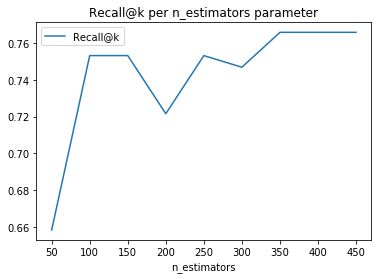

In [8]:
pd.DataFrame(results).plot(x="n_estimators", y="Recall@k", title="Recall@k per n_estimators parameter")

### Fitting model with best parameters

In [9]:
print("Fitting...")
clf = IsolationForest(n_estimators=400, random_state=0).fit(train_inliers)

print("Predicting...")
train_preds = clf.decision_function(X_train)
train_preds = pd.Series(train_preds).reset_index(drop=True)
test_preds = clf.decision_function(X_test)
test_preds = pd.Series(test_preds).reset_index(drop=True)

Fitting...
Predicting...


Results over top-10000 most anomalous predictions


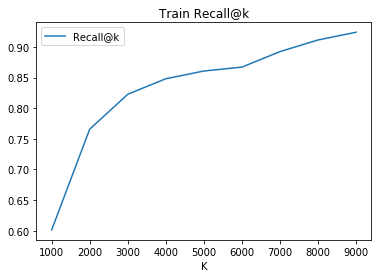

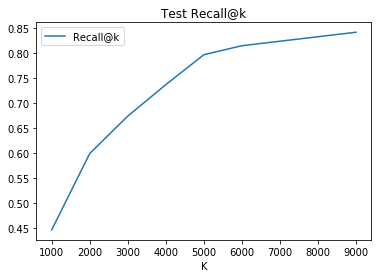

Train Recall@10000: 0.9240506329113924
Train Recall@10000 AUC: 0.6731012658227848

Test Recall@10000: 0.8473053892215568
Test Recall@10000 AUC: 0.5919161676646707


In [10]:
print(f"Results over top-{k_total} most anomalous predictions")
collect_results(train_preds, test_preds, y_train, y_test, k=k_total, wanted_range=wanted_range, ascending=True)

Results over top-2000 most anomalous predictions


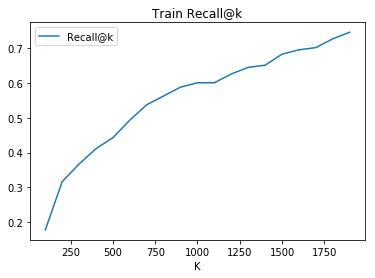

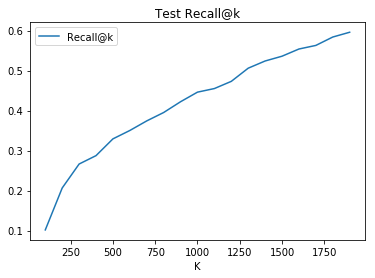

Train Recall@2000: 0.7658227848101266
Train Recall@2000 AUC: 0.5060126582278481

Test Recall@2000: 0.5988023952095808
Test Recall@2000 AUC: 0.38106287425149693


In [11]:
print(f"Results over top-{k_optimize} most anomalous predictions")
collect_results(train_preds, test_preds, y_train, y_test, k=k_optimize, wanted_range=range(100,2000,100), ascending=True)

## INNE 

### Get best parameters
Simple hypertuning - Only n_samples

In [12]:
from inne import INNE
results_inne = {"n_samples":[],
          "Recall@k":[]}

for i in range(50,500, 50):
    print(f"Working on n_samples={i}")
    print("Fitting...")
    clf = INNE(n_samples=i, sample_size=100, n_jobs=8)
    clf.fit(train_inliers_sc)

    print("Predicting...")
    train_preds = clf.predict(X_train_sc)
    train_preds = pd.Series(train_preds).reset_index(drop=True)
    
    X_train_concat_results = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),
                                        train_preds], axis=1)
    curr_recall = recall(X_train_concat_results, k_optimize, ascending=False)
    
    results_inne["n_samples"].append(i)
    results_inne["Recall@k"].append(curr_recall)
    print(f"Train Recall@{k_optimize}: {curr_recall}")
    print()
    

Working on n_samples=50
Fitting...
Predicting...
Train Recall@2000: 0.189873417721519

Working on n_samples=100
Fitting...
Predicting...
Train Recall@2000: 0.4810126582278481

Working on n_samples=150
Fitting...
Predicting...
Train Recall@2000: 0.7278481012658228

Working on n_samples=200
Fitting...
Predicting...
Train Recall@2000: 0.8481012658227848

Working on n_samples=250
Fitting...
Predicting...
Train Recall@2000: 0.8544303797468354

Working on n_samples=300
Fitting...
Predicting...
Train Recall@2000: 0.8481012658227848

Working on n_samples=350
Fitting...
Predicting...
Train Recall@2000: 0.8481012658227848

Working on n_samples=400
Fitting...
Predicting...
Train Recall@2000: 0.8607594936708861

Working on n_samples=450
Fitting...
Predicting...
Train Recall@2000: 0.8607594936708861



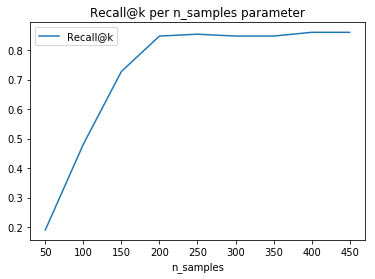

In [13]:
pd.DataFrame(results_inne).plot(x="n_samples", y="Recall@k", title="Recall@k per n_samples parameter")

## Fitting model with best parameters

Fitting...
Predicting...


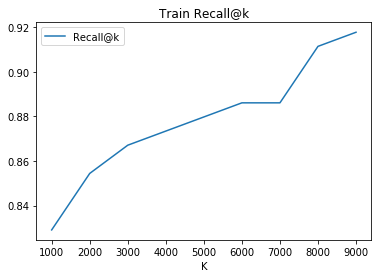

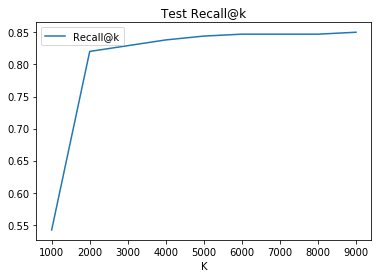

Train Recall@10000: 0.9240506329113924
Train Recall@10000 AUC: 0.7031645569620253

Test Recall@10000: 0.8502994011976048
Test Recall@10000 AUC: 0.6570359281437126


In [14]:

print("Fitting...")
clf = INNE(n_samples=500, sample_size=100, n_jobs=8)
clf.fit(train_inliers_sc)

print("Predicting...")
train_preds = clf.predict(X_train_sc)
train_preds = pd.Series(train_preds).reset_index(drop=True)
test_preds = clf.predict(X_test_sc)
test_preds = pd.Series(test_preds).reset_index(drop=True)

collect_results(train_preds, test_preds, y_train, y_test, k=k_total, wanted_range=wanted_range, ascending=False)

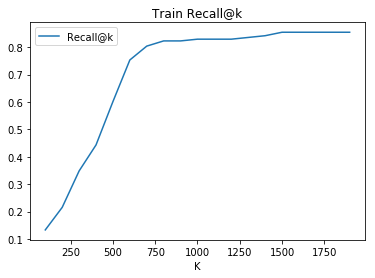

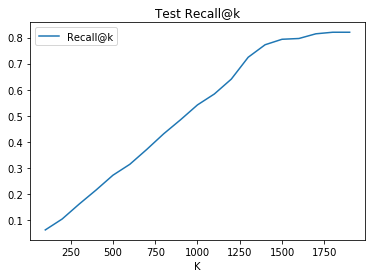

Train Recall@2000: 0.8544303797468354
Train Recall@2000 AUC: 0.6443037974683544

Test Recall@2000: 0.8203592814371258
Test Recall@2000 AUC: 0.4642964071856288


In [15]:
collect_results(train_preds, test_preds, y_train, y_test, k=k_optimize, wanted_range=range(100,2000,100), ascending=False)

# Final thoughts

- INNE is better than Isolation Forest on this dataset on the metric I selected. INNE do better ranking of anomalous instances, and also find overall more anomalous instances in the top-K results.


- INNE memory complexity is O(S*N) where S is the number of samples and N is the sample size. Usually $S\in[50,150]$ and $N\in[100,500]$. So it isn't depend on the dataset size. The author of the paper reported lower values, but those values didn't work on this dataset. So you should explore it. 


- INNE running time is a problem. I optimized what I could with NumPy objects, and parallelized the computation when needed. It not great, but it runs at a reasonable time on this dataset (minutes, depends on sample size). If you have some improvement suggestions please let me know.




# Resources

I want to thank Thanks to Tharindu R. Bandaragoda et al for their paper - 
"Efficient Anomaly Detection by Isolation Using Nearest Neighbour Ensemble"
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7022664&tag=1

It is a simple but powerful algorithm, and I had a lot of fun to implement it on python. Here is their original implementation in JAVA - https://github.com/tharindurb/iNNE

This GitHub repository contains also a PDF file with slides that provides another explanation for the algorithm.